In [21]:
import logging

import pickle
import torch.nn.functional as F

import torch
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from torch.distributions import constraints
from torch import nn
import pyro
import pyro.distributions as dist
import pyro.optim as optim
from pyro.infer import SVI, Trace_ELBO
from pyro.optim import Adam
from pyro.infer import Predictive
import seaborn as sns
from pyro import poutine
from sklearn import metrics
from pyro.infer.autoguide import AutoMultivariateNormal, AutoLowRankMultivariateNormal, init_to_mean,init_to_feasible,AutoNormal

In [2]:

with open('data_all.pickle', 'rb') as handle:
    data = pickle.load(handle)
print(data.shape)

(1127, 5237)


In [3]:
class PM_test_normals(nn.Module):
    # by default our latent space is 50-dimensional
    # and we use 400 hidden units
    def __init__(self, train, dim):
        super().__init__()
        """Build the Probabilistic Matrix Factorization model using pymc3.



        """
        self.dim = dim   
        self.data = train.copy()
        self.n, self.m = self.data.shape
        self.map = None
        self.bounds = (0.0,1.0)
        self.losses = None
        self.predictions = None
        self.returned = None


        # Perform mean value imputation
    
        
        # Low precision reflects uncertainty; prevents overfitting.
        # Set to the mean variance across users and items.
        self.alpha_u = np.mean(self.data, axis=1).mean()
        self.alpha_v =  np.std(self.data, axis=1).mean()
        
        self.beta_u = np.mean(self.data, axis=0).mean() 
        self.beta_v =  np.std(self.data, axis=0).mean()
        self.bias = self.data.mean()


    def model(self, train):

        drug_plate = pyro.plate("drug_latents", self.n, dim= -1) #independent users
        sideeffect_plate = pyro.plate("sideeffect_latents", self.m, dim= -1) #independent items

        with drug_plate: 
            UA = pyro.sample("UA", dist.Normal(self.alpha_u, self.beta_u).expand([self.dim]).to_event(1))
            #UA_int = pyro.sample("UAint", dist.Normal(0., 1.))
        
        with sideeffect_plate:
            VA = pyro.sample("VA", dist.Normal(self.alpha_v, self.beta_v).expand([self.dim]).to_event(1))
            #possibly add intercepts VA_int = pyro.sample("VA", dist.Normal(0., 1.).to_event(1))
       
        u2_plate = pyro.plate("u2_plate", self.n, dim=-2)

        with sideeffect_plate, u2_plate: 
         
             Y = pyro.sample("target", dist.Poisson(torch.abs(UA@VA.T)), obs=train ) 
             return Y
        

    def guide(self, train=None, mask=None):

        d_alpha = pyro.param('d_alpha', torch.ones(self.n,self.dim), constraint=constraints.positive)#*self.user_mean)
        d_beta = pyro.param('d_beta', 0.5*torch.ones(self.n,self.dim), constraint=constraints.positive)
       # int_mean = pyro.param('int_mean', torch.tensor(1.)*self.user_mean)
       # mov_cov = pyro.param('mov_cov', torch.tensor(1.)*0.1,
          #                  constraint=constraints.positive)

        s_alpha = pyro.param('s_alpha', torch.ones(self.m,self.dim), constraint=constraints.positive)#*self.item_mean)
        s_beta = pyro.param('s_beta', 0.5*torch.ones(self.m,self.dim), constraint=constraints.positive)
        drug_plate = pyro.plate("drug_latents", self.n, dim= -1) #independent users
        sideeffect_plate = pyro.plate("sideeffect_latents", self.m, dim= -1) #independent items

        with drug_plate: 
            UA = pyro.sample("UA", dist.Normal(d_alpha, d_beta).to_event(1))
           # UA_int = pyro.sample("UAint", dist.Normal(int_mean, mov_cov).to_event(1))
        with sideeffect_plate: 
            VA = pyro.sample("VA", dist.Normal(s_alpha, s_beta).to_event(1))
    
    def train_SVI(self,train,nsteps=250, lr = 0.05, lrd = 1):
        logging.basicConfig(format='%(message)s', level=logging.INFO)
        svi = SVI(self.model,
        self.guide,
        optim.ClippedAdam({"lr": lr, "lrd": lrd}),
        loss=Trace_ELBO())
        losses = []
        for step in range(nsteps):
            elbo = svi.step(torch.from_numpy(train).float())
            losses.append(elbo)
            if step % 10 == 0:
                print("Elbo loss: {}".format(elbo))
        self.losses = losses
        #constrained_params = list(pyro.get_param_store().values())
        #PARAMS = [p.unconstrained() for p in constrained_params]
        #print(PARAMS)
        return losses
    
    def sample_predict(self, nsamples=500 , verbose=True):
    
        predictive_svi = Predictive(self.model, guide=self.guide, num_samples=nsamples)(None )
        if (verbose):
            for k, v in predictive_svi.items():
                print(f"{k}: {tuple(v.shape)}")
        table = predictive_svi["target"].numpy()
        print(predictive_svi["UA"].numpy())
        print(table)
        self.returned = table
        mc_table = table.mean(axis = 0)
        mc_table_std = table.std(axis = 0)
        mc_table[mc_table < self.bounds[1]] = self.bounds[0]
        mc_table[mc_table >= self.bounds[1]] = self.bounds[1]
        self.predictions = mc_table
        
    
    def rmse(self,test):
        low, high = self.bounds
        test_data = test.copy()
        test_data[test_data < high] = low
        test_data[test_data >= high] = high
        sqerror = abs(test_data - self.predictions) ** 2  # squared error array
        mse = sqerror.sum()/(test_data.shape[0]*test_data.shape[1])
        print("PMF MAP training RMSE: %.5f" % np.sqrt(mse))
        fpr, tpr, thresholds = metrics.roc_curve(test_data.astype(int).flatten(),  self.predictions.astype(int).flatten(), pos_label=1)
        metrics.auc(fpr, tpr)
        print("AUC: %.5f" % metrics.auc(fpr, tpr))
        return np.sqrt(mse) , metrics.auc(fpr, tpr)

    def get_predictions(self):
        return (self.returned,self.predictions)

    
   
       

In [17]:
with open('data_all.pickle', 'rb') as handle:
    data = pickle.load(handle)
#test = PM_test_normals(train=data, dim=100)
test.train_SVI(data)

Elbo loss: 11032911.0
Elbo loss: 11068511.84375
Elbo loss: 11050304.84375
Elbo loss: 11050780.90625
Elbo loss: 11040708.65625
Elbo loss: 11021631.03125
Elbo loss: 11024094.9375
Elbo loss: 11028051.75
Elbo loss: 11021524.4375
Elbo loss: 11008319.9375
Elbo loss: 11024987.0
Elbo loss: 11004866.25
Elbo loss: 11028199.875
Elbo loss: 10998948.25
Elbo loss: 10987375.78125
Elbo loss: 10989856.71875
Elbo loss: 11019588.1875
Elbo loss: 11003183.15625
Elbo loss: 10978126.71875
Elbo loss: 10997625.28125
Elbo loss: 10994099.03125
Elbo loss: 10986366.65625
Elbo loss: 10979696.65625
Elbo loss: 10980806.875
Elbo loss: 10998653.78125


[11032911.0,
 11044462.75,
 11053495.0,
 11061768.5625,
 11042515.40625,
 11063420.40625,
 11069750.90625,
 11057034.5,
 11047723.0,
 11081979.90625,
 11068511.84375,
 11061734.875,
 11072390.09375,
 11060435.03125,
 11046889.28125,
 11047261.6875,
 11074660.625,
 11060324.71875,
 11048173.5,
 11050282.625,
 11050304.84375,
 11053263.84375,
 11056498.4375,
 11054417.0625,
 11053458.15625,
 11052717.15625,
 11039722.09375,
 11053493.96875,
 11042741.375,
 11056841.34375,
 11050780.90625,
 11052430.5,
 11048126.90625,
 11037115.78125,
 11036961.375,
 11045653.03125,
 11031082.71875,
 11032750.0625,
 11039990.40625,
 11031403.8125,
 11040708.65625,
 11038959.625,
 11045292.84375,
 11037182.15625,
 11024076.34375,
 11026448.84375,
 11036721.8125,
 11031765.46875,
 11034305.90625,
 11042307.34375,
 11021631.03125,
 11026123.6875,
 11012452.25,
 11036509.6875,
 11026770.9375,
 11021405.28125,
 11011261.6875,
 11004763.0625,
 11020791.09375,
 11041669.09375,
 11024094.9375,
 11036309.0625,
 1

In [18]:
predictive_svi = Predictive(test.model, guide=test.guide, num_samples=1000)(None )
for k, v in predictive_svi.items():
    print(f"{k}: {tuple(v.shape)}")
table = predictive_svi["target"].numpy()
print(table)

UA: (1000, 1, 1127, 100)
VA: (1000, 1, 5237, 100)
target: (1000, 1127, 5237)
[[[ 0.  0.  0. ...  0.  0.  1.]
  [ 1.  0.  0. ...  0.  0.  0.]
  [ 2.  1.  0. ...  7.  6.  0.]
  ...
  [ 5.  1.  0. ...  8. 13.  0.]
  [ 1.  0.  0. ...  0. 17.  0.]
  [ 0.  0.  0. ...  0.  0.  0.]]

 [[ 1.  0.  0. ...  1.  0.  1.]
  [ 3.  0.  0. ...  0.  1.  3.]
  [ 1.  0.  0. ...  1.  4.  0.]
  ...
  [12.  0.  0. ... 10.  8.  2.]
  [ 0.  0.  0. ...  4. 19.  0.]
  [ 0.  0.  0. ...  1.  0.  0.]]

 [[ 0.  0.  0. ...  0.  0.  1.]
  [ 1.  0.  0. ...  0.  0.  0.]
  [ 0.  0.  0. ...  2.  8.  0.]
  ...
  [ 8.  0.  1. ...  8.  8.  3.]
  [ 2.  0.  0. ...  2. 19.  0.]
  [ 0.  0.  0. ...  0.  0.  0.]]

 ...

 [[ 4.  0.  0. ...  1.  2.  4.]
  [ 0.  0.  0. ...  0.  0.  0.]
  [ 0.  0.  0. ...  2.  5.  0.]
  ...
  [ 9.  1.  0. ...  9. 13.  2.]
  [ 4.  0.  0. ...  2. 19.  0.]
  [ 0.  0.  0. ...  0.  0.  0.]]

 [[ 1.  0.  0. ...  0.  4.  2.]
  [ 0.  0.  0. ...  0.  0.  0.]
  [ 1.  0.  1. ...  3.  3.  0.]
  ...
  [11.  0.  2. 

In [19]:
table = predictive_svi["UA"].numpy()
table2 = predictive_svi["VA"].numpy()
table = table.mean(axis=0).mean(axis=0)
table2 = table2.mean(axis=0).mean(axis=0)
print(table.shape)
print(table2.shape)

(1127, 100)
(5237, 100)


In [20]:
with open('UA.pickle', 'wb') as handle:
    pickle.dump(table, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open('VA.pickle', 'wb') as handle:
    pickle.dump(table2, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [10]:
with open('UA.pickle', 'rb') as handle:
    data2 = pickle.load(handle)
print(data2.shape)

(1127, 100)


In [11]:
def mix_weights(beta):
    beta1m_cumprod = (1 - beta).cumprod(-1)
    return F.pad(beta, (0, 1), value=1) * F.pad(beta1m_cumprod, (1, 0), value=1)

def model(data):
    with pyro.plate("beta_plate", T-1):
        beta = pyro.sample("beta", dist.Beta(1,alpha))

    with pyro.plate("mu_plate", T):
        mu = pyro.sample("mu", dist.MultivariateNormal(torch.zeros(100), 5 * torch.eye(100)))
        #cov = pyro.sample("cov", dist.Gamma(torch.ones(1), 2*torch.ones(1)).expand([100]).to_event(1) )

    with pyro.plate("data", N):
        z = pyro.sample("z", dist.Categorical(mix_weights(beta)))
        pyro.sample("obs", dist.MultivariateNormal(mu[z], torch.eye(100)), obs=data)
def guide(data):
    kappa = pyro.param('kappa', lambda: dist.Uniform(0, 2).sample([T-1]), constraint=constraints.positive)
    tau = pyro.param('tau', lambda: dist.MultivariateNormal(torch.zeros(100), 3 * torch.eye(100)).sample([T]))
    phi = pyro.param('phi', lambda: dist.Dirichlet(1/T * torch.ones(T)).sample([N]), constraint=constraints.simplex)
   # d_alpha = pyro.param('d_alpha', torch.ones(self.n,self.dim), constraint=constraints.positive)#*self.user_mean)
   # d_beta = pyro.param('d_beta', 0.5*torch.ones(self.n,self.dim), constraint=constraints.positive)

    with pyro.plate("beta_plate", T-1):
        q_beta = pyro.sample("beta", dist.Beta(torch.ones(T-1), kappa))

    with pyro.plate("mu_plate", T):
        q_mu = pyro.sample("mu", dist.MultivariateNormal(tau, torch.eye(100)))
       # cov = pyro.sample("cov", dist.Gamma(d_alpha, d_beta).to_event(1))

    with pyro.plate("data", N):
        z = pyro.sample("z", dist.Categorical(phi))

In [12]:
import tqdm
T = 500
N=1127
optim = Adam({"lr": 0.05})
svi = SVI(model, guide, optim, loss=Trace_ELBO())
losses = []

def train(num_iterations):
    pyro.clear_param_store()
    for j in range(num_iterations):
        loss = svi.step(data)
        losses.append(loss)

def truncate(alpha, centers, weights):
    threshold = alpha**-1 / 1000.
    true_centers = centers[weights > threshold]
    true_weights = weights[weights > threshold] / torch.sum(weights[weights > threshold])
    return true_centers, true_weights

alpha = 1
#train(1000)

# We make a point-estimate of our model parameters using the posterior means of tau and phi for the centers and weights
#Bayes_Centers_01, Bayes_Weights_01 = truncate(alpha, pyro.param("tau").detach(), torch.mean(pyro.param("phi").detach(), dim=0))


In [13]:
df = pd.DataFrame(data2)
df_test = df.sample(frac=0.1)
df_test

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
14,0.000054,2.505660e-06,5.403511e-05,8.791711e-04,1.257142e-05,0.000030,0.001865,0.000898,0.000030,0.000233,...,0.000010,2.677705e-05,-0.000023,0.000204,-0.000010,0.000009,0.000073,0.000085,2.418886e-04,3.171958e-05
188,0.026934,6.833655e-02,6.942817e-02,4.978475e-02,2.042324e-02,0.000499,0.621244,0.266700,0.017884,0.003635,...,-0.000009,7.106790e-03,0.000130,0.035804,0.001562,0.002062,0.001434,0.203421,1.215186e-02,1.234963e-04
1095,0.005646,1.495173e-02,-8.591634e-05,-4.505122e-04,4.853699e-05,0.071626,0.968767,0.068144,-0.000061,-0.000006,...,-0.000044,2.744103e-03,-0.000265,0.000836,0.028086,-0.000129,0.000033,0.027910,-2.188478e-05,-2.101945e-05
588,0.000008,2.822439e-06,-4.704575e-06,-1.568835e-05,-1.533800e-07,0.000006,-0.000006,0.000003,-0.000020,0.000005,...,0.000002,6.485552e-06,0.000034,-0.000005,0.000003,0.000006,-0.000009,0.000309,2.946209e-06,1.121897e-05
388,0.122159,5.024661e-03,5.126290e-05,6.304253e-04,4.737614e-04,0.021113,0.046456,0.032192,0.000054,0.000114,...,0.016061,3.376488e-03,0.020783,0.000329,0.140225,0.000012,0.004551,0.006014,1.472808e-05,3.717123e-06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
848,0.000015,8.214032e-09,8.119380e-05,2.133203e-01,3.888287e-02,-0.000058,0.000041,0.154544,0.270999,0.000016,...,0.002439,5.405352e-07,5.074065,0.000500,-0.000720,0.000009,0.000029,-0.000224,1.059395e-04,-2.465230e-06
561,0.000031,1.308786e-02,1.549961e-05,3.283193e-02,-1.856965e-05,-0.000020,-0.000014,0.048926,0.003264,0.004732,...,-0.000001,2.523636e-03,0.002559,0.000143,0.000003,0.001016,0.000001,0.006942,2.202661e-07,1.877044e-05
760,0.000006,1.650343e-05,2.211373e-07,-2.793321e-07,2.386591e-05,0.000125,0.000016,0.000067,-0.000010,0.000010,...,0.000086,2.542116e-04,0.000018,0.000014,0.000005,-0.000011,0.000014,-0.000026,2.169983e-03,9.022845e-07
148,0.000014,2.383662e-04,2.922654e-06,-1.053169e-05,6.467514e-05,0.000015,0.002184,0.000030,0.000225,0.000044,...,0.000004,7.848259e-04,0.000142,0.000117,0.000014,0.000002,0.000007,0.000033,2.837732e-05,-1.210644e-06


In [14]:
data = torch.tensor(df.drop(df_test.index).values, dtype=torch.float)
data_test = torch.tensor(df_test.values, dtype=torch.float)
print(data.shape)

torch.Size([1014, 100])


In [26]:
s = data_test.reshape(-1,100,1,1)
print(s.shape)

torch.Size([113, 100, 1, 1])


In [15]:
df_test = df.sample(frac=0.1)
data = torch.tensor(df.drop(df_test.index).values, dtype=torch.float)
data_test = torch.tensor(df_test.values, dtype=torch.float)
N = data.shape[0]
N_test = data_test.shape[0]

alphas = [0.05, 0.1, 0.5, 0.75, 0.9, 1., 1.25, 1.5, 2, 2.5, 3]
log_predictives = []

for val in alphas:
    alpha = val
    T = 77
    svi = SVI(model, guide, optim, loss=Trace_ELBO())
    train(500)

    S = 500 # number of Monte Carlo samples to use in posterior predictive computations

    # Using pyro's built in posterior predictive class:
    posterior = Predictive(guide, num_samples=S, return_sites=["beta", "mu"])(data)
    post_pred_weights = mix_weights(posterior["beta"])
    post_pred_clusters = posterior["mu"]
    print(post_pred_weights.shape)
    print(post_pred_clusters.shape)

    log_prob = (post_pred_weights.log() + dist.MultivariateNormal(post_pred_clusters, torch.eye(100)).log_prob(data_test.reshape(-1, 1, 1,100))).logsumexp(-1)
    mean_log_prob = log_prob.logsumexp(-1) - np.log(S)
    log_posterior_predictive = mean_log_prob.sum(-1)
    log_predictives.append(log_posterior_predictive)

    

torch.Size([500, 77])
torch.Size([500, 77, 100])
torch.Size([500, 77])
torch.Size([500, 77, 100])
torch.Size([500, 77])
torch.Size([500, 77, 100])
torch.Size([500, 77])
torch.Size([500, 77, 100])
torch.Size([500, 77])
torch.Size([500, 77, 100])
torch.Size([500, 77])
torch.Size([500, 77, 100])
torch.Size([500, 77])
torch.Size([500, 77, 100])
torch.Size([500, 77])
torch.Size([500, 77, 100])
torch.Size([500, 77])
torch.Size([500, 77, 100])
torch.Size([500, 77])
torch.Size([500, 77, 100])
torch.Size([500, 77])
torch.Size([500, 77, 100])


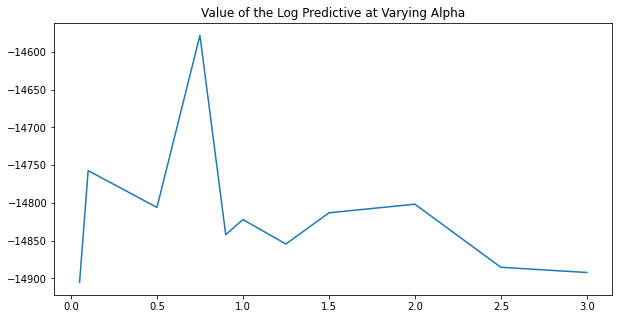

In [18]:
plt.figure(figsize=(10, 5))
plt.plot(alphas, log_predictives)
plt.title("Value of the Log Predictive at Varying Alpha")
plt.savefig("log_predictive_drugs_alpha.png")
plt.show()

In [8]:
with open('VA.pickle', 'rb') as handle:
    data2 = pickle.load(handle)
print(data2.shape)
df = pd.DataFrame(data2)
df_test = df.sample(frac=0.1)
df_test
data = torch.tensor(df.drop(df_test.index).values, dtype=torch.float)
data_test = torch.tensor(df_test.values, dtype=torch.float)
print(data.shape)
df_test = df.sample(frac=0.1)
data = torch.tensor(df.drop(df_test.index).values, dtype=torch.float)
data_test = torch.tensor(df_test.values, dtype=torch.float)
N = data.shape[0]
N_test = data_test.shape[0]

alphas = [0.05, 0.1, 0.5, 0.75, 0.9, 1., 1.25, 1.5, 2, 2.5, 3]
log_predictives = []

for val in alphas:
    alpha = val
    T = 150
    svi = SVI(model, guide, optim, loss=Trace_ELBO())
    train(500)

    S = 500 # number of Monte Carlo samples to use in posterior predictive computations

    # Using pyro's built in posterior predictive class:
    posterior = Predictive(guide, num_samples=S, return_sites=["beta", "mu"])(data)
    post_pred_weights = mix_weights(posterior["beta"])
    post_pred_clusters = posterior["mu"]
    print(post_pred_weights.shape)
    print(post_pred_clusters.shape)

    log_prob = (post_pred_weights.log() + dist.MultivariateNormal(post_pred_clusters, torch.eye(100)).log_prob(data_test.reshape(-1, 1, 1,100))).logsumexp(-1)
    mean_log_prob = log_prob.logsumexp(-1) - np.log(S)
    log_posterior_predictive = mean_log_prob.sum(-1)
    log_predictives.append(log_posterior_predictive)

    

(5237, 100)
torch.Size([4713, 100])
torch.Size([500, 150])
torch.Size([500, 150, 100])
torch.Size([500, 150])
torch.Size([500, 150, 100])
torch.Size([500, 150])
torch.Size([500, 150, 100])
torch.Size([500, 150])
torch.Size([500, 150, 100])
torch.Size([500, 150])
torch.Size([500, 150, 100])
torch.Size([500, 150])
torch.Size([500, 150, 100])
torch.Size([500, 150])
torch.Size([500, 150, 100])
torch.Size([500, 150])
torch.Size([500, 150, 100])
torch.Size([500, 150])
torch.Size([500, 150, 100])
torch.Size([500, 150])
torch.Size([500, 150, 100])
torch.Size([500, 150])
torch.Size([500, 150, 100])


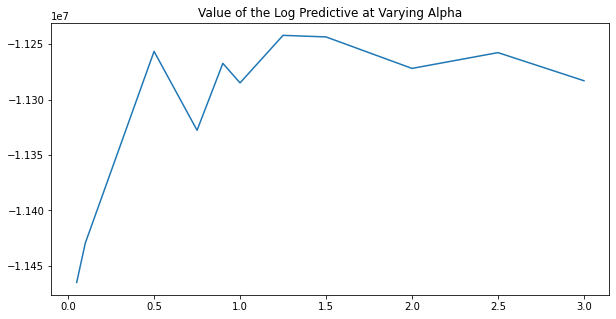

In [9]:
plt.figure(figsize=(10, 5))
plt.plot(alphas, log_predictives)
plt.title("Value of the Log Predictive at Varying Alpha")
plt.show()

In [31]:

def model2(data, T, alpha):
    with pyro.plate("beta_plate", T-1):
        beta = pyro.sample("beta", dist.Beta(1,alpha))

    with pyro.plate("mu_plate", T):
        mu = pyro.sample("mu", dist.MultivariateNormal(torch.zeros(100), 1 * torch.eye(100)))
    #     cov = pyro.sample("cov", dist.Gamma(torch.ones(1), 2*torch.ones(1)).expand([100]).to_event(1) )

    # cov_matrix = torch.ones(T,100,100)
    # for i in range(0,T):
    #     cov_matrix[i] = cov[i]*torch.eye(100)

    with pyro.plate("data", N):
     
        z = pyro.sample("z", dist.Categorical(mix_weights(beta)))
        pyro.sample("obs", dist.MultivariateNormal(mu[z],torch.eye(100)), obs=data)

def guide2(data, T , alpha):
    kappa = pyro.param('kappa', lambda: dist.Uniform(0, 2).sample([T-1]), constraint=constraints.positive)
    tau = pyro.param('tau', lambda: dist.MultivariateNormal(torch.zeros(100), 1 * torch.eye(100)).sample([T]))
    phi = pyro.param('phi', lambda: dist.Dirichlet(1/T * torch.ones(T)).sample([N]), constraint=constraints.simplex)
    # d_alpha = pyro.param('d_alpha', torch.ones(T,100), constraint=constraints.positive)#*self.user_mean)
    # d_beta = pyro.param('d_beta', torch.ones(T,100), constraint=constraints.positive)

    with pyro.plate("beta_plate", T-1):
        q_beta = pyro.sample("beta", dist.Beta(torch.ones(T-1), kappa))

    with pyro.plate("mu_plate", T):
        q_mu = pyro.sample("mu", dist.MultivariateNormal(tau, torch.eye(100)))
        #cov = pyro.sample("cov", dist.Gamma(d_alpha, d_beta).to_event(1))

    with pyro.plate("data", N):
        z = pyro.sample("z", dist.Categorical(phi))

def train2(num_iterations, trainin, T_final, alpha):
    pyro.clear_param_store()
    optimize = optim.ClippedAdam({"lr": 0.05, "lrd": 1})
    svi = SVI(model2, guide2, optimize, loss=Trace_ELBO())
    losses = []
    for j in range(num_iterations):
        loss = svi.step(trainin, T_final, alpha)
        losses.append(loss)
        if j % 10 == 0:
                        print("Elbo loss: {}".format(loss))
    return losses

def truncate(alpha, centers, weights):
    threshold = alpha**-1 / 100.
    true_centers = centers[weights > threshold]
    true_weights = weights[weights > threshold] / torch.sum(weights[weights > threshold])
    return true_centers, true_weights

def data_prep(data):
    df = pd.DataFrame(data)
    df_test = df.sample(frac=0.1)
    data_train = torch.tensor(df.drop(df_test.index).values, dtype=torch.float)
    data_test = torch.tensor(df_test.values, dtype=torch.float) 
    return data_train, data_test

def pred_likel(data_train,data_test):
    N = data_train.shape[0]
    N_test = data_test.shape[0]
    alpha = 1.5
    #train2(1000, data_train, 150,alpha)
    #Bayes_Centers_01, Bayes_Weights_01 = truncate(alpha, pyro.param("tau").detach(), torch.mean(pyro.param("phi").detach(), dim=0))
    #T_final=Bayes_Centers_01.shape[0]
    alphas = [  1.]
    log_predictives = []

    for val in alphas:
        alpha = val
        T = 77
        T_final =77
        train2(200, data_train, T_final, alpha)

        S = 100 # number of Monte Carlo samples to use in posterior predictive computations

        # Using pyro's built in posterior predictive class:
        posterior = Predictive(guide2, num_samples=S, return_sites=["beta", "mu"])(data_train , T, val)
        post_pred_weights = mix_weights(posterior["beta"])
        post_pred_clusters = posterior["mu"]
        log_prob = (post_pred_weights.log() + dist.MultivariateNormal(post_pred_clusters, torch.eye(100)).log_prob(data_test.reshape(-1, 1, 1,100))).logsumexp(-1)
        mean_log_prob = log_prob.logsumexp(-1) - np.log(S)
        log_posterior_predictive = mean_log_prob.sum(-1)
        log_predictives.append(log_posterior_predictive)
        print(log_posterior_predictive)
    return log_predictives , T_final


In [34]:
with open('VA.pickle', 'rb') as handle:
     data2 = pickle.load(handle)
trainin,test = data_prep(data2)
N = data2.shape[0]
#lp = pred_likel(trainin, test)
final_parameters =  train2(500, torch.tensor(data2), 77, 1)


Elbo loss: 173288313.90675354
Elbo loss: 172505618.76594925
Elbo loss: 171871983.53495026
Elbo loss: 171388864.1018772
Elbo loss: 170951900.960598
Elbo loss: 170682426.31591225
Elbo loss: 170467509.85723877
Elbo loss: 170265653.49627304
Elbo loss: 170076141.9026432
Elbo loss: 169997395.82261658
Elbo loss: 169924816.8072281
Elbo loss: 169889990.9589157
Elbo loss: 169806400.63453674
Elbo loss: 169761285.2206192
Elbo loss: 169755012.19657135
Elbo loss: 169709710.3192749
Elbo loss: 169704477.03313446
Elbo loss: 169771174.149765
Elbo loss: 169718521.03840637
Elbo loss: 169680027.58013916
Elbo loss: 169667397.50823975
Elbo loss: 169691238.11062622
Elbo loss: 169785875.90507507
Elbo loss: 169697218.2558899
Elbo loss: 169781716.567688
Elbo loss: 169776376.68788147
Elbo loss: 169718951.36291504
Elbo loss: 169760152.15397644
Elbo loss: 169793088.83518982
Elbo loss: 169734973.19906616
Elbo loss: 169803382.43711853
Elbo loss: 169772889.2016449
Elbo loss: 169760141.03894043
Elbo loss: 169810291.333

In [35]:
t=pyro.param("tau").detach()
phi = pyro.param("phi").detach()
print(t.shape)
print(phi.shape)
data_all = t,phi
with open('se_param.pickle', 'wb') as handle:
    pickle.dump(data_all, handle, protocol=pickle.HIGHEST_PROTOCOL)


torch.Size([77, 100])
torch.Size([5237, 77])
